# Expected SARSA and $n$-step bootstrapping

In this notebook, you will implement expected SARSA and $n$-step bookstrapping described in Chapters 6 and 7 of [Sutton and Barto's book, Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html).  

### Install dependencies

In [65]:
! pip install numpy pandas

### Imports

In [66]:
import numpy as np
import random
import sys          # We use sys to get the max value of a float
import pandas as pd # We only use pandas for displaying tables nicely
pd.options.display.float_format = '{:,.3f}'.format

### ```World``` class and globals

The ```World``` is a grid represented as a two-dimensional array of characters where each character can represent free space, an obstacle, or a terminal. Each non-obstacle cell is associated with a reward that an agent gets for moving to that cell (can be 0). The size of the world is _width_ $\times$ _height_ characters.

A _state_ is a tuple $(x,y)$.

An empty world is created in the ```__init__``` method. Obstacles, rewards and terminals can then be added with ```add_obstacle``` and ```add_reward```.

To calculate the next state of an agent (that is, an agent is in some state $s = (x,y)$ and performs and action, $a$), ```get_next_state()```should be called.

In [67]:
# Globals:
ACTIONS = ("up", "down", "left", "right")

# Rewards, terminals and obstacles are characters:
REWARDS = {" ": 0, ".": 0.1, "+": 10, "-": -10}
TERMINALS = ("+", "-") # Note a terminal should also have a reward assigned
OBSTACLES = ("#")

# Discount factor
gamma = 1

# The probability of a random move:
rand_move_probability = 0

class World:
  def __init__(self, width, height):
    self.width = width
    self.height = height
    # Create an empty world where the agent can move to all cells
    self.grid = np.full((width, height), ' ', dtype='U1')

  def add_obstacle(self, start_x, start_y, end_x=None, end_y=None):
    """
    Create an obstacle in either a single cell or rectangle.
    """
    if end_x == None: end_x = start_x
    if end_y == None: end_y = start_y

    self.grid[start_x:end_x + 1, start_y:end_y + 1] = OBSTACLES[0]

  def add_reward(self, x, y, reward):
    assert reward in REWARDS, f"{reward} not in {REWARDS}"
    self.grid[x, y] = reward

  def add_terminal(self, x, y, terminal):
    assert terminal in TERMINALS, f"{terminal} not in {TERMINALS}"
    self.grid[x, y] = terminal

  def is_obstacle(self, x, y):
    if x < 0 or x >= self.width or y < 0 or y >= self.height:
      return True
    else:
      return self.grid[x ,y] in OBSTACLES

  def is_terminal(self, x, y):
    return self.grid[x ,y] in TERMINALS

  def get_reward(self, x, y):
    """
    Return the reward associated with a given location
    """
    return REWARDS[self.grid[x, y]]

  def get_next_state(self, current_state, action):
    """
    Get the next state given a current state and an action. The outcome can be
    stochastic  where rand_move_probability determines the probability of
    ignoring the action and performing a random move.
    """
    assert action in ACTIONS, f"Unknown acion {action} must be one of {ACTIONS}"

    x, y = current_state

    # If our current state is a terminal, there is no next state
    if self.grid[x, y] in TERMINALS:
      return None

    # Check of a random action should be performed:
    if np.random.rand() < rand_move_probability:
      action = np.random.choice(ACTIONS)

    if action == "up":      y -= 1
    elif action == "down":  y += 1
    elif action == "left":  x -= 1
    elif action == "right": x += 1

    # If the next state is an obstacle, stay in the current state
    return (x, y) if not self.is_obstacle(x, y) else current_state


## A simple world

We will create a simple $8\times8$ world, where the agent should start in the top-left corner at $(0,0)$ and find its way to the bottom-right corner at $(7,7)$.

In [68]:
world = World(8, 8)
world.add_terminal(7, 7, "+")

print(world.grid.T)

[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' '+']]


## Exercise: Expected SARSA

Implement and test expected SARSA, see page 133 of [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). The implementation of expected SARSA is very similar to regular SARSA, so you can use your SARSA implementation as a starting point for your expected SARSA implementation.

In [69]:
# TODO: Implement your code here -- you need a Q-table to keep track of action
#       value estimates and a policy-function that returns an epsilon greedy
#       policy based on your estimates.

Q = np.random.rand(world.width,world.height,len(ACTIONS))

def sarsa_policy(state):
  actions = {a: epsilon/len(ACTIONS) for a in ACTIONS}
  actions[ACTIONS[np.argmax(Q[state])]] = 1-epsilon + epsilon/len(ACTIONS)
  return actions

def expected_sarsa(world, start_state, policy):
    for episode in range(EPISODES):

        current_state = start_state
        possible_actions = policy(current_state)
        action = random.choices(population = list(possible_actions.keys()), weights=possible_actions.values(),k=1)

        while not world.is_terminal(current_state[0],current_state[1]):
            next_state = world.get_next_state(current_state, *action)
            #next_x, next_y = next_state
            reward = world.get_reward(*next_state)


            possible_actions = policy(next_state)
            next_action = random.choices(population = list(possible_actions.keys()), weights=possible_actions.values(),k=1)

            sum = 0;
            for a in ACTIONS:
              sum += possible_actions[a] * Q[next_state[0],next_state[1], ACTIONS.index(a)]

            Q[current_state[0], current_state[1], ACTIONS.index(*action)] += alpha*(reward + gamma* sum - Q[current_state[0],current_state[1], ACTIONS.index(*action)])

            current_state = next_state
            action = next_action
    return Q



Try your expected SARSA implementation on the $8\times8$ world defined above.

In [70]:
### TODO: try your expected SARSA implementation
EPISODES = 10
epsilon = 0.1
alpha = 0.05
gamma = 0.9

start_state = (0,0)
Q = expected_sarsa(world, (0, 0), sarsa_policy)

best_action = np.full((world.width,world.height), "right")

for x in range(world.width):
  for y in range(world.height):
    for action in ACTIONS:
      #print(f"State: {x,y} - Action: {action} - Value: {Q[x,y,ACTIONS.index(action)]}")
      best_action[x,y] = ACTIONS[np.argmax(Q[x,y])]
    #print("\n")

display(pd.DataFrame(world.grid.T))
display(pd.DataFrame(best_action.T))

,0,1,2,3,4,5,6,7
0,,,,,,,,
1,,,,,,,,
2,,,,,,,,
3,,,,,,,,
4,,,,,,,,
5,,,,,,,,
6,,,,,,,,
7,,,,,,,,+


,0,1,2,3,4,5,6,7
0,right,right,down,down,left,left,down,right
1,up,right,down,left,left,right,right,up
2,up,up,left,down,left,right,right,down
3,up,down,down,down,down,up,right,down
4,down,left,down,left,right,left,right,down
5,down,up,right,left,left,up,up,down
6,up,left,up,right,left,down,right,down
7,down,right,right,down,right,left,left,up


### Test and compare your expected SARSA implementation

Test your implementation on the simple $8 \times 8$ world defined above with, ```rand_move_probability = 0.0```, $\epsilon = 0.1$, and $\gamma = 0.9$. Compare the performance of expected SARSA with normal SARSA. How long does it take for the respective methods to solve the tasks optimally (that is, number of steps that an agent takes from start to finish = _width_ + _height_ $-2 = 14$).

Remember that for expected SARSA, you can use a learning rate of 1 ($\alpha = 1)$, whereas for SARSA, you should try different learning rates.


In [71]:
rand_move_probability = 0.0
epsilon = 0.1
gamma = 0.9

### TODO: Compare the performance of SARSA (different alphas) and
###       expected SARSA (alpha = 1). You need to run multiple
###       experiments (e.g. 100 per setting) and then take the average
###       to get a proper estimate of the general performance.

def sarsa(world, start_state):
    for episode in range(EPISODES):
        current_state = start_state
        #x, y = current_state
        action = epsilon_greedy_policy(current_state, epsilon=0.1)

        while not world.is_terminal(current_state[0],current_state[1]):
            next_state = world.get_next_state(current_state, action)
            #next_x, next_y = next_state
            reward = world.get_reward(*next_state)

            next_action = epsilon_greedy_policy(next_state, epsilon=0.1)

            Q[current_state[0],current_state[1], ACTIONS.index(action)] += alpha * (
                reward + gamma * Q[next_state[0], next_state[1], ACTIONS.index(next_action)] -
                Q[current_state[0],current_state[1], ACTIONS.index(action)]
            )

            current_state = next_state
            #x, y = current_state
            action = next_action

    return Q

def epsilon_greedy_policy(state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.choice(ACTIONS)
    else:
        return ACTIONS[np.argmax(Q[state])]


start_state = (0,0)
Q = expected_sarsa(world, (0, 0), sarsa_policy)

best_action = np.full((world.width,world.height), "right")

for x in range(world.width):
  for y in range(world.height):
    for action in ACTIONS:
      #print(f"State: {x,y} - Action: {action} - Value: {Q[x,y,ACTIONS.index(action)]}")
      best_action[x,y] = ACTIONS[np.argmax(Q[x,y])]
    #print("\n")


display(pd.DataFrame(world.grid.T))
print("EXPECTED SARSA")
display(pd.DataFrame(best_action.T))


Q = sarsa(world, (0, 0))
best_action2 = np.full((world.width,world.height), "right")

for x in range(world.width):
  for y in range(world.height):
    for action in ACTIONS:
      #print(f"State: {x,y} - Action: {action} - Value: {Q[x,y,ACTIONS.index(action)]}")
      best_action2[x,y] = ACTIONS[np.argmax(Q[x,y])]
    #print("\n")

print("SARSA")
display(pd.DataFrame(best_action.T))


,0,1,2,3,4,5,6,7
0,,,,,,,,
1,,,,,,,,
2,,,,,,,,
3,,,,,,,,
4,,,,,,,,
5,,,,,,,,
6,,,,,,,,
7,,,,,,,,+


EXPECTED SARSA


,0,1,2,3,4,5,6,7
0,down,right,down,left,left,left,down,right
1,up,right,down,down,left,right,right,up
2,right,right,right,right,up,right,left,down
3,down,down,down,left,left,up,right,down
4,down,left,right,left,up,down,right,down
5,right,up,up,down,left,right,up,down
6,up,left,left,left,left,down,right,down
7,down,right,down,up,right,left,left,up


SARSA


,0,1,2,3,4,5,6,7
0,down,right,down,left,left,left,down,right
1,up,right,down,down,left,right,right,up
2,right,right,right,right,up,right,left,down
3,down,down,down,left,left,up,right,down
4,down,left,right,left,up,down,right,down
5,right,up,up,down,left,right,up,down
6,up,left,left,left,left,down,right,down
7,down,right,down,up,right,left,left,up


## Exercise: $n$-step on-policy SARSA or $n$-step on-policy expected SARSA

Here, you should implement on-policy $n$-step bootstrapping. You can either implement $n$-step SARSA or $n$-step expected SARSA. See Chapter 7 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html) and page 147 for $n$-step SARSA.

Test you implementation with different values of $n$ either on the $8\times8$ world above or on the ```WindyGridWorld``` from previous lectures. It is up to you to decide how to measure performance: it could, for instance, be the average episode length after a limited number of episodes (for instance $10$), how long it takes to solve the task optimally, like in the exercise on expected SARSA above, or something else.

For the world that you choose, you have to answer the question: "What is a good value for $n$?"

In [72]:
### TODO: Implment and test n-step SARSA or n-step expected SARSA.
Q = np.random.rand(world.width,world.height,len(ACTIONS))


def nstep_sarsa(world,policy,start_state,n):
  total_steps = 0
  for episode in range(EPISODES):
    St = []
    At = []
    Rt = [0]
    current_state = start_state
    possible_actions = policy(current_state)
    action = random.choices(population = list(possible_actions.keys()), weights=possible_actions.values(),k=1)

    St.append(current_state)
    At.append(*action)

    T = np.inf
    t = 0
    tau = 0
    G = 0

    while tau != T-1:
      if t < T:
        next_state = world.get_next_state(current_state, *action)
        reward = world.get_reward(*next_state)

        St.append(next_state)
        Rt.append(reward)

        current_state = next_state

        if world.is_terminal(next_state[0],next_state[1]):
          T = t + 1

        else:
          possible_actions = policy(current_state)
          action = random.choices(population = list(possible_actions.keys()), weights=possible_actions.values(),k=1)
          At.append(*action)

      tau = t - n+1
      if tau >= 0:
        G = 0
        for i in range(tau+1,min(tau+n,T)+1):
          G += np.power(gamma,(i-tau-1)) * Rt[i]

        if tau + n < T:
          G += np.power(gamma,n) * Q[St[tau+n][0],St[tau+n][1],ACTIONS.index(At[tau+n])]

        Q[St[tau][0],St[tau][1],ACTIONS.index(At[tau])] += alpha * (G - Q[St[tau][0],St[tau][1],ACTIONS.index(At[tau])])
      t +=1
    total_steps += len(St)-1
  return Q, total_steps


In [73]:
start = (0,0)
EPISODES = 20
epsilon = 0.1
alpha = 0.05
gamma = 0.9
n = 3
steps = 0
stepList = []

for n in range(n,n+1):
   steps = 0
   for _ in range(100):
     Q = np.random.rand(world.width,world.height,len(ACTIONS))
     Q = nstep_sarsa(world,sarsa_policy,start,n)[0]
     steps += nstep_sarsa(world,sarsa_policy,start,n)[1]
   print(f"Average number of steps: {steps/100}")
   #print(f"Average number of steps for n = {n}: {steps/100}")

   #stepList.append(steps/100)
#plot_average_steps(len(stepList),stepList)

best_action = np.full((world.width,world.height), "neverset")


for x in range(world.width):
  for y in range(world.height):
    for action in ACTIONS:
      #print(f"State: {x,y} - Action: {action} - Value: {Q[x,y,ACTIONS.index(action)]}")
      best_action[x,y] = ACTIONS[np.argmax(Q[x,y])]
    #print("\n")
best_action[7,7] = "GOAL"
print("n-step SARSA")
print(f"n = {n}")
print(f"Episodes = {EPISODES}")
display(pd.DataFrame(best_action.T))

Average number of steps: 563.92
n-step SARSA
n = 3
Episodes = 20


,0,1,2,3,4,5,6,7
0,right,right,right,right,right,right,down,down
1,right,up,right,left,up,down,down,down
2,down,left,down,left,left,down,down,left
3,left,down,left,up,down,left,right,down
4,right,up,down,up,up,left,right,down
5,up,up,right,down,up,right,up,down
6,down,right,down,left,up,up,down,down
7,up,up,down,left,left,left,left,GOAL


In [106]:
n = 3
EPISODES = 100
Q = np.random.rand(world.width,world.height,len(ACTIONS))
Q, stepsnoget = nstep_sarsa(world,sarsa_policy,start,n)
for x in range(world.width):
  for y in range(world.height):
    for action in ACTIONS:
      #print(f"State: {x,y} - Action: {action} - Value: {Q[x,y,ACTIONS.index(action)]}")
      best_action[x,y] = ACTIONS[np.argmax(Q[x,y])]
    #print("\n")
best_action[7,7] = "GOAL"
print("n-step SARSA")
print(stepsnoget/EPISODES)
print(f"n = {n}")
print(f"Episodes = {EPISODES}")
display(pd.DataFrame(best_action.T))

n-step SARSA
43.89
n = 3
Episodes = 100


,0,1,2,3,4,5,6,7
0,down,down,right,down,right,down,down,left
1,down,right,down,down,left,left,up,right
2,right,down,left,down,down,right,up,down
3,down,right,down,left,left,right,right,left
4,down,left,down,down,right,down,down,left
5,right,right,down,right,right,right,down,up
6,right,right,down,down,up,up,down,right
7,right,right,right,right,right,right,right,GOAL


In [75]:
import matplotlib.pyplot as plt

# Data
n_values = list(range(1, 16))
average_steps = [76.35, 66.44, 41.85, 29.54, 23.58, 25.33, 24.27, 23.91,
                 23.66, 23.05, 23.93, 21.57, 25.79, 23.99, 23.21]

def plot_average_steps(n, average_steps):
  n_values = list(range(1, n))
  # Plot
  plt.figure(figsize=(10, 6))
  plt.plot(n_values, average_steps, marker='o', linestyle='-', color='b', label='Average Steps')
  plt.title('Average Number of Steps vs n', fontsize=14)
  plt.xlabel('n', fontsize=12)
  plt.ylabel('Average Number of Steps', fontsize=12)
  plt.xticks(n_values)
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.legend()
  plt.show()

In [76]:
display(pd.DataFrame(world.grid.T))

,0,1,2,3,4,5,6,7
0,,,,,,,,
1,,,,,,,,
2,,,,,,,,
3,,,,,,,,
4,,,,,,,,
5,,,,,,,,
6,,,,,,,,
7,,,,,,,,+


hejsa
polse
hejsa
polse
hejsa
polse
hejsa
polse
hejsa
polse
hejsa
polse
hejsa
polse
hejsa
polse
hejsa
polse


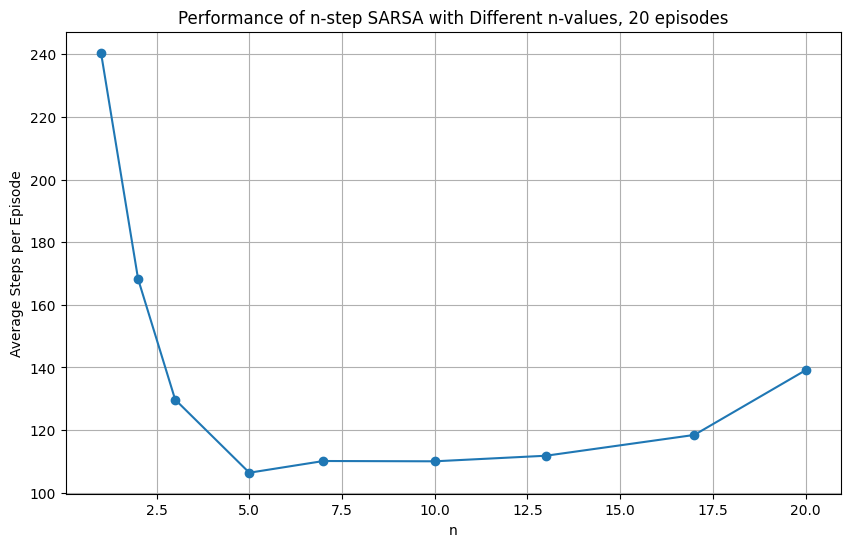

In [77]:
# Antal episoder og n-værdier
EPISODES = 20
n_values = [1, 2, 3, 5, 7, 10, 13, 17, 20]  # Forskellige værdier for n
alpha = 0.1
gamma = 0.9
epsilon = 0.1

# Initialisering af verden og politik (tilpasses dit setup)
# world = World(8, 8)  # Eksempelverden
policy = sarsa_policy  # Tilpasses din epsilon-greedy funktion
start_state = (0, 0)

# Samle trin for hver n-værdi
steps_per_n = []

# Test for hver værdi af n
for n in n_values:
    avg_steps = []
    print("hejsa")
    for instance in range(100):  # Gennemsnit over 10 instances
        Q = np.random.rand(world.width, world.height, len(ACTIONS))  # Reset Q for hver n
        Q, total_steps = nstep_sarsa(world, policy, start_state, n)
        avg_steps.append(total_steps)  # Gem antallet af trin
    print("polse")
    steps_per_n.append(np.mean(avg_steps)/EPISODES)  # Gennemsnit over instances

# Plot resultater
plt.figure(figsize=(10, 6))
plt.plot(n_values, steps_per_n, marker='o')
plt.xlabel("n")
plt.ylabel("Average Steps per Episode")
plt.title("Performance of n-step SARSA with Different n-values, 20 episodes")
plt.grid()
plt.show()